In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from scipy.optimize import curve_fit
from scipy.integrate import simps
import statsmodels.api as sm # import stats package
from scipy.optimize import curve_fit

In [2]:
from fair import *
from fair.scripts.data_retrieval import *

## Define Functions

In [3]:
## calculate cost of perturbation due to carbon
## input: temperature profile, perturbed temperature profile, total consumption, and discount function

def cost_of_perturbation(T, T_perturb, W, discount_function, gamma=2, D0=0.00267):
    S_Wt = D0*T**gamma
    S_Wt_perturb = D0*T_perturb**gamma
    consumption_loss_fraction = S_Wt_perturb-S_Wt
    absolute_consumption_loss = consumption_loss_fraction*W
    discounted_consumption_loss = absolute_consumption_loss*discount_function
    area = simps(discounted_consumption_loss, dx=1)
    cost = area*10**12  # convert to dollar amount
    
    return cost

In [4]:
## calculate abatement given a carbon price

def abatement(P, P0, P_h=44, r=20, s=18, Am=1.1):
    A = Am/(1+((P-P0)/P_h)**(-r/s))
    
    return A

In [5]:
## Nick's function to get SSP emissions data (use to get historical data to 2019)

def get_ssp_emissions(ssp, end_year = 2019):
    
    emms = RCMIP_to_FaIR_input_emms(ssp).interpolate().loc[1750:end_year]

    ## rebase emission-driven forcings & species with natural emissions included in RCMIP to zero @ 1750
    rebase_species = ['so2','nox','co','nmvoc','bc','nh3','oc','nox_avi','methyl_bromide','methyl_chloride','chcl3','ch2cl2']
    emms.loc[:,rebase_species] -= emms.loc[1750,rebase_species]
    
    return emms

In [6]:
## calculate emissions from forecasted abatement and CO2 baseline

def abatement_to_emissions(forecasted_abatement, CO2_baseline):
    CO2_emissions = CO2_baseline*(1-forecasted_abatement)
    
    return CO2_emissions

In [7]:
def create_total_consumption(first_year, last_historical_year, years, T_forecast, T_2019, T_forecast_years, g_2019, g_grad):
    g = g_2019 - g_grad*(T_forecast[:-1]-T_2019)
    W_2019 = 80
    
    W = []

    W_historical = [W_2019] * (last_historical_year - first_year + 1)

    W_forecast = []

    W_previous_year = W_historical[-1]

    for i in range(len(T_forecast_years) - 1):
        W_this_year = W_previous_year*np.exp(g[i])
        W_forecast.append(W_this_year)
        W_previous_year = W_this_year

    W = W_historical + W_forecast

    W = np.asarray(W)
    
    return W

# Steps outlined in Email

## 1. Create Unperturbed Temperature Profile

In [8]:
# get historical data (taken from chrisroadmap)

T_gas_df = pd.read_csv("T_gas.csv", index_col=0)

T_2019 = T_gas_df['CO2_best'][2019]

In [9]:
start_year = 1750
last_historical_year = 2019
end_year = 2500

years = np.arange(start_year, end_year+1)
T_forecast_years = np.arange(last_historical_year, end_year+1)
T_forecast_length = end_year - last_historical_year + 1

In [10]:
delta_T = 2
alpha = 0.02
T_forecast = T_2019 + delta_T * (1 - np.exp(-alpha*np.arange(T_forecast_length)))

In [11]:
T = np.concatenate([T_gas_df['CO2_best'],T_forecast[1:]])

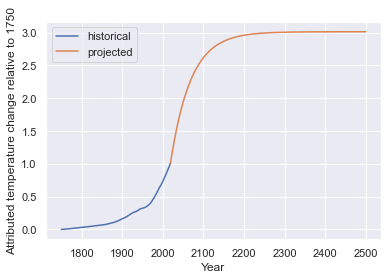

In [12]:
plt.plot(T_gas_df['CO2_best'], label="historical")
plt.plot(T_forecast_years, T_forecast, label="projected")
plt.xlabel("Year")
plt.ylabel("Attributed temperature change relative to 1750")
plt.legend()

## Total Consumption

Text(0, 0.5, 'g')

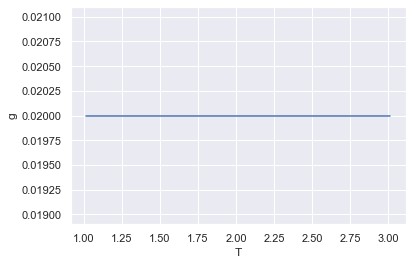

In [49]:
g_2019 = 0.02
g_grad = 0
# g_grad = 0.001

g = g_2019 - g_grad*(T_forecast[:-1]-T_2019)
plt.plot(T_forecast[:-1], g)

plt.xlabel("T")
plt.ylabel("g")

Text(0, 0.5, 'g')

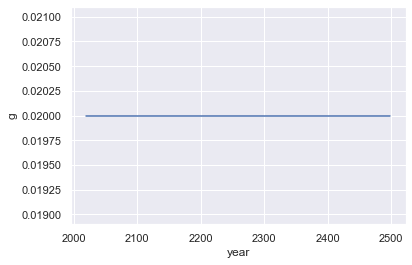

In [50]:
plt.plot(T_forecast_years[:-1], g)
plt.xlabel("year")
plt.ylabel("g")

In [51]:
W = create_total_consumption(start_year, last_historical_year, years, T_forecast, T_2019, T_forecast_years, g_2019, g_grad)

In [52]:
## previously used formula for consumption growth

consumption_growth = 0.02
W_2019 = 80
W2 = []
for i in range(len(years)):
    W2.append(W_2019 * np.exp(consumption_growth * (i - (last_historical_year - start_year))))
W2 = np.asarray(W2)

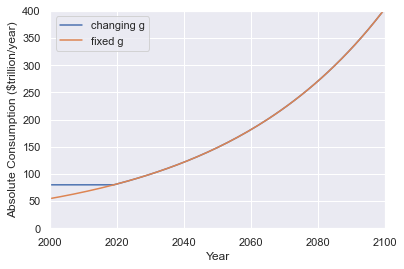

In [53]:
plt.plot(years, W, label="changing g")
plt.plot(years, W2, label="fixed g")

plt.xlabel("Year")
plt.ylabel("Absolute Consumption ($trillion/year)")
plt.xlim(2000, 2100)
plt.ylim(0, 400)
plt.legend()

alternative functional form for above for the fast transition

## 2. Calculate SCC as a function of time for a range of years

In [54]:
## years to calculate SCC
first_perturbed_year = last_historical_year
last_perturbed_year = 2100
year_of_perturbation = np.arange(first_perturbed_year, last_perturbed_year+1)


SCC_list = []

for j in range(len(year_of_perturbation)):
    ## define perturbed temperature profile for a given year
    T_TCRE = 0.00054  # need to check this for FAIR!
    k_s = 0.12

    T_p = np.zeros(T_forecast_length)
    for i in range(len(T_forecast_years)):
        if year_of_perturbation[j] <= T_forecast_years[i]:
            T_p[i] = T_TCRE*(1-np.exp(-k_s*(T_forecast_years[i]-year_of_perturbation[j])))
    T_forecast_perturbed = T_forecast+T_p
    T_perturbed = np.concatenate([T_gas_df['CO2_best'],T_forecast_perturbed[1:]])

    ## define discount function
    num_of_years = len(years)
    consumption_discount = 0.035
    discount_function = np.zeros(num_of_years)

    for i in range(num_of_years):
        if years[i] >= year_of_perturbation[j]:
            discount_function[i] = np.exp(-consumption_discount*(years[i]-year_of_perturbation[j]))
    
    ## calculate SCC
    cost = cost_of_perturbation(T=T, T_perturb=T_perturbed, W=W, discount_function=discount_function)
    SCC = cost/(10**9)
    SCC_list.append(SCC)

In [55]:
SCC_array = np.asarray(SCC_list)  # convert to numpy array

Text(0, 0.5, 'SCC ($)')

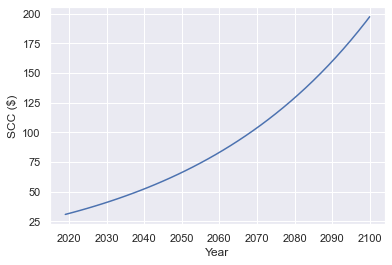

In [56]:
plt.plot(year_of_perturbation, SCC_array)
plt.xlabel("Year")
plt.ylabel("SCC ($)")

N.B. The SCC calculation is currently not valid for years close to 2500, since the

### Fit SCC line to forecast

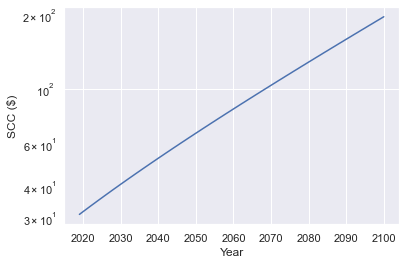

In [57]:
plt.plot(year_of_perturbation, SCC_array)
plt.xlabel("Year")
plt.ylabel("SCC ($)")
plt.yscale("log")

In [58]:
log_SCC = np.log(SCC_array)

In [59]:
## add linear fit
X = sm.add_constant(year_of_perturbation) # add a constant to fit
results = sm.OLS(log_SCC, X).fit() # save results of fit

Text(0, 0.5, 'ln(SCC)')

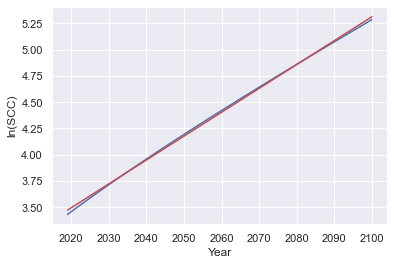

In [60]:
#Plot with Fit & Summary 
plt.plot(year_of_perturbation, log_SCC)
plt.plot(year_of_perturbation, results.params[0]+results.params[1]*year_of_perturbation, 'r' , label='fitted_line')
plt.xlabel("Year")
plt.ylabel("ln(SCC)")

In [61]:
np.exp(3.17)

23.80748435642867

In [62]:
np.exp(4.4)

81.45086866496814

In [63]:
SCC_forecasted = np.exp(results.params[0]+results.params[1]*T_forecast_years)

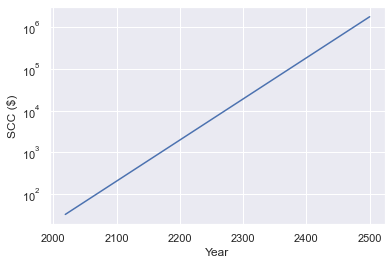

In [64]:
plt.plot(T_forecast_years, SCC_forecasted)
plt.xlabel("Year")
plt.ylabel("SCC ($)")
plt.yscale("log")

In [65]:
# SCC_forecasted = SCC_array

## 3. Abatement as a function of time

In [66]:
P0 = SCC_forecasted[0]

In [67]:
forecasted_abatement = abatement(SCC_forecasted, P0)

/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_54603/4173862749.py:4: RuntimeWarning: divide by zero encountered in power
  A = Am/(1+((P-P0)/P_h)**(-r/s))


Text(0, 0.5, 'Abatement')

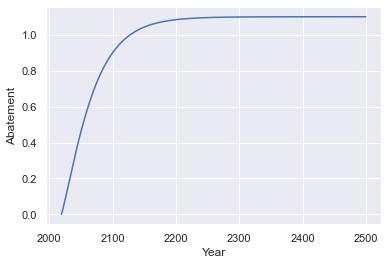

In [68]:
plt.plot(T_forecast_years, forecasted_abatement)
plt.xlabel("Year")
plt.ylabel("Abatement")

## 4. Abatement to emissions

In [69]:
# choose ssp to use
ssp='ssp245'

# get emissions data using imported scripts + convert into FaIRv2.0.0-alpha multiindex format
ssp_emms = pd.concat([get_ssp_emissions(ssp)],axis=1,keys=[ssp])

In [70]:
ssp245_CO2_past = ssp_emms["ssp245"]["carbon_dioxide"]*(44/12)  

In [71]:
CO2_baseline = ssp245_CO2_past[2019] # set baseline to current emissions

In [72]:
forecasted_emissions = abatement_to_emissions(forecasted_abatement, CO2_baseline)

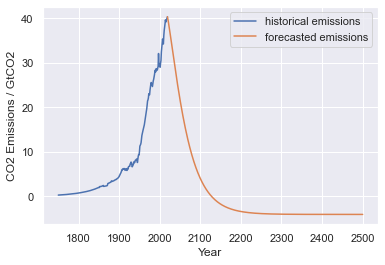

In [73]:
plt.plot(ssp245_CO2_past, label="historical emissions")
plt.plot(T_forecast_years, forecasted_emissions, label="forecasted emissions")
plt.xlabel("Year")
plt.ylabel("CO2 Emissions / GtCO2")
plt.legend()

## 5. Cumulative Emissions to Temperature Change

In [74]:
cumulative_emissions = []

for i in range(len(T_forecast_years)):
    area = simps(forecasted_emissions[:i+1], dx=1)
    cumulative_emissions.append(area)

In [75]:
cumulative_emissions_array = np.asarray(cumulative_emissions)

In [76]:
temperature_change = T_TCRE*cumulative_emissions_array

In [77]:
temperature_change_plateau = np.array(temperature_change, copy=True)

print(np.argmax(temperature_change_plateau))

for i in range(len(temperature_change_plateau)):
    if i > np.argmax(temperature_change_plateau):
        temperature_change_plateau[i] = max(temperature_change_plateau)

109


In [78]:
max(temperature_change)

0.8530487639016521

In [79]:
T_forecast_iteration0 = T_2019 + temperature_change
T_forecast_iteration0_plateau = T_2019 + temperature_change_plateau

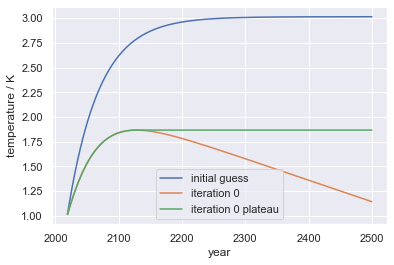

In [80]:
plt.plot(T_forecast_years, T_forecast, label="initial guess")
plt.plot(T_forecast_years, T_forecast_iteration0, label="iteration 0")
plt.plot(T_forecast_years, T_forecast_iteration0_plateau, label="iteration 0 plateau")
plt.xlabel("year")
plt.ylabel("temperature / K")
plt.legend()

# Iterating Further

In [81]:
T_forecast_first_loop = T_forecast_iteration0_plateau
T_forecast_iteration = T_forecast_iteration0_plateau

/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_54603/4173862749.py:4: RuntimeWarning: divide by zero encountered in power
  A = Am/(1+((P-P0)/P_h)**(-r/s))
/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_54603/4173862749.py:4: RuntimeWarning: divide by zero encountered in power
  A = Am/(1+((P-P0)/P_h)**(-r/s))
/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_54603/4173862749.py:4: RuntimeWarning: divide by zero encountered in power
  A = Am/(1+((P-P0)/P_h)**(-r/s))
/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_54603/4173862749.py:4: RuntimeWarning: divide by zero encountered in power
  A = Am/(1+((P-P0)/P_h)**(-r/s))
/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_54603/4173862749.py:4: RuntimeWarning: divide by zero encountered in power
  A = Am/(1+((P-P0)/P_h)**(-r/s))


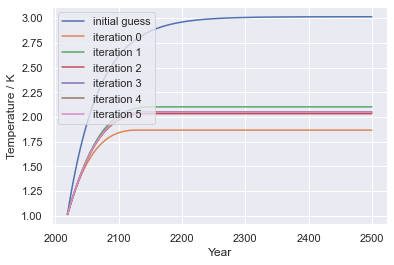

In [82]:
num_of_iterations = 5

first_perturbed_year = last_historical_year
last_perturbed_year = 2100

year_of_perturbation = np.arange(first_perturbed_year, last_perturbed_year+1)

plt.plot(T_forecast_years, T_forecast, label="initial guess")
plt.plot(T_forecast_years, T_forecast_first_loop, label="iteration 0")

for k in range(num_of_iterations):
    T_iteration = np.concatenate([T_gas_df['CO2_best'],T_forecast_iteration[1:]])

    W = create_total_consumption(first_year=start_year, last_historical_year=last_historical_year, years=years, T_forecast=T_forecast_iteration, T_2019=T_2019, T_forecast_years=T_forecast_years, g_2019=g_2019, g_grad=g_grad)
    
    SCC_list = []

    for j in range(len(year_of_perturbation)):
        ## define perturbation
        T_TCRE = 0.00054  # need to check this! *100 for 100GtCO2 added
        k_s = 0.12

        T_p = np.zeros(T_forecast_length)

        for i in range(len(T_forecast_years)):
            if year_of_perturbation[j] <= T_forecast_years[i]:
                T_p[i] = T_TCRE*(1-np.exp(-k_s*(T_forecast_years[i]-year_of_perturbation[j])))

        T_forecast_perturbed = T_forecast_iteration+T_p

        T_perturbed = np.concatenate([T_gas_df['CO2_best'],T_forecast_perturbed[1:]])

        ## define discount function
        num_of_years = len(years)

        consumption_discount = 0.035
        discount_function = np.zeros(num_of_years)

        for i in range(num_of_years):
            if years[i] >= year_of_perturbation[j]:
                discount_function[i] = np.exp(-consumption_discount*(years[i]-year_of_perturbation[j]))
        cost = cost_of_perturbation(T=T_iteration, T_perturb=T_perturbed, W=W, discount_function=discount_function)
        SCC = cost/(10**9)
        SCC_list.append(SCC)

    SCC_array = np.asarray(SCC_list)
    log_SCC = np.log(SCC_array)

    ## add linear fit
    X = sm.add_constant(year_of_perturbation) # add a constant to fit
    results = sm.OLS(log_SCC, X).fit() # save results of fit

    SCC_forecasted = np.exp(results.params[0]+results.params[1]*T_forecast_years)

    P0 = SCC_forecasted[0]

    forecasted_abatement = abatement(SCC_forecasted, P0)
    forecasted_emissions = abatement_to_emissions(forecasted_abatement, CO2_baseline)

    cumulative_emissions = []

    for i in range(len(T_forecast_years)):
        area = simps(forecasted_emissions[:i+1], dx=1)
        cumulative_emissions.append(area)

    cumulative_emissions_array = np.asarray(cumulative_emissions)

    temperature_change = T_TCRE*cumulative_emissions_array
    
    # to return to the previous method remove for loop and T_forecast_iteration = T_2019 + temperature_change
    temperature_change_plateau = np.array(temperature_change, copy=True)
    for i in range(len(temperature_change_plateau)):
        if i > np.argmax(temperature_change_plateau):
            temperature_change_plateau[i] = max(temperature_change_plateau)

    T_forecast_iteration = T_2019 + temperature_change_plateau
    
    plt.plot(T_forecast_years, T_forecast_iteration, label="iteration "+str(k+1))

plt.xlabel("Year")
plt.ylabel("Temperature / K")
plt.legend()

### Max Temperature

In [83]:
## peak Temperature
max(T_forecast_iteration)

2.0475253966852023

2.0475253966851574 (floating point error)

In [84]:
SCC_forecasted[0]

24.633017404399375